# Project - Parallelizing convex hull using CUDA
## Ruhama Mubaraka Fizza


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-z9c22dap
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-z9c22dap
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4305 sha256=fa9919badc97001007afb170ac7a90148a3193f31a18630c025cf0171a6f34fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-euzdc5js/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


#### **GPU INFORMATION**

In [ ]:
!nvidia-smi

Sat May  6 09:01:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### **CPU INFORMATION**

In [ ]:
!uname -a
!cat /proc/cpuinfo
!cat /proc/meminfo

Linux 8e2a50fca7bc 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swap

### **QHULL LIBRARY**

Following are the code cells to download and run qhull library

In [ ]:
!apt-get install -y qhull-bin
!apt-get install -y python3-qhull

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  geomview
The following NEW packages will be installed:
  qhull-bin
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 337 kB of archives.
After this operation, 2,257 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 qhull-bin amd64 2015.2-4 [337 kB]
Fetched 337 kB in 0s (712 kB/s)
Selecting previously unselected package qhull-bin.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../qhull-bin_2015.2-4_amd64.deb ...
Unpacking qhull-bin (2015.2-4) ...
Setting up qhull-bin (2015.2-4) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python3-qhull


In [ ]:
# generate 10 random 2d points and compute the hull
!rbox 10 D2 | qhull


Convex hull of 10 points in 2-d:

  Number of vertices: 4
  Number of facets: 4

Statistics for: rbox 10 D2 | qhull

  Number of points processed: 4
  Number of hyperplanes created: 6
  Number of distance tests for qhull: 52
  CPU seconds to compute hull (after input): 3.6e-05



#### **VISUALIZATION**

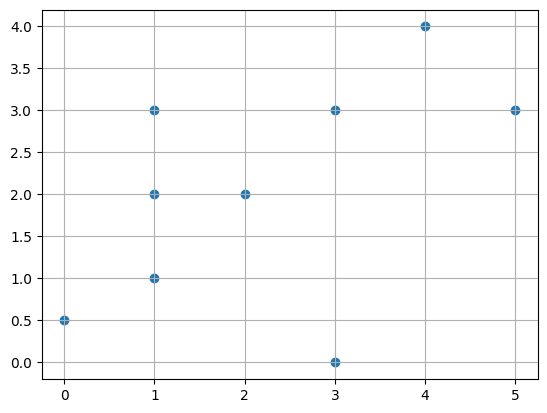

In [ ]:
import matplotlib.pyplot as plt
points = [(1, 3), (1, 1), (2, 2), (4, 4), (0, 0.5), (1, 2), (3, 0), (3, 3), (5,3)]
# {0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}
plt.scatter([i[0] for i in points], [i[1] for i in points])
plt.grid(True)

### **JARVIS SCAN**

**JARVIS MARCH CPU**

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>

struct Point {
    int x;
    int y;
};

int orientation(struct Point p, struct Point q, struct Point r) {
    int val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y);
    if (val == 0) {
        return 0;
    } else if (val > 0) {
        return 1;
    } else {
        return 2;
    }
}

void convexHull(struct Point points[], int n) {
    if (n < 3) {
        return;
    }

    int leftmost = 0;
    for (int i = 1; i < n; i++) {
        if (points[i].x < points[leftmost].x) {
            leftmost = i;
        }
    }

    int p = leftmost, q;
    do {
       // printf("(%d, %d)\n", points[p].x, points[p].y);
        q = (p + 1) % n;
        for (int i = 0; i < n; i++) {
            if (orientation(points[p], points[i], points[q]) == 2) {
                q = i;
            }
        }
        p = q;
    } while (p != leftmost);
}

int main() {
    
    int N_arr[5] = {1000, 10000, 100000, 1000000, 10000000};
      FILE *fp;
      fp = fopen("/content/jarvis-cpu.txt", "w+");
      char buffer[20] = {0}; 
      clock_t cpu_start, cpu_end;

       for (int num_runs = 0; num_runs < 5; num_runs++){
          int N = N_arr[num_runs];   
          struct Point *points = (Point*) malloc(sizeof(struct Point) * N);
          srand(time(NULL));

          sprintf(buffer, "%d", N);
          fputs(buffer, fp);
          fputs("\n", fp);

          for (int i = 0; i < N; i++) {
            points[i].x = rand()  % 1000 + 1;
            points[i].y = rand()  % 1000 + 1;
          }

           cpu_start = clock();
           convexHull(points, N);
           cpu_end = clock();
          double cpu_total_time = (double)(cpu_end - cpu_start) / CLOCKS_PER_SEC * 1000.0;

          sprintf(buffer, "%f", cpu_total_time);
          fputs(buffer, fp);
          fputs("\n", fp);

       }     
       





    // struct Point points[] = {{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};
  // int n = sizeof(points) / sizeof(points[0]);
    // convexHull(points, n);
    return 0;
}


**JARVIS MARCH GPU**

In [ ]:
%%cu
#include <stdio.h>

struct Point {
    int x;
    int y;
};

int orientation(struct Point p, struct Point q, struct Point r) {
    int val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y);
    if (val == 0) {
        return 0;
    } else if (val > 0) {
        return 1;
    } else {
        return 2;
    }
}

__global__ void findLeftmostPoint(Point* points, int* leftmostPoint, int n) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    if (tid < n) {
        int oldVal, newVal;
        do {
            oldVal = *leftmostPoint;
            if (points[tid].x < points[oldVal].x ||
                (points[tid].x == points[oldVal].x && points[tid].y < points[oldVal].y)) {
                newVal = tid;
            } else {
                newVal = oldVal;
            }
        } while (oldVal != atomicCAS(leftmostPoint, oldVal, newVal));
    }
}

void convexHull(Point points[], int n, FILE *fp) {
     int N_threads[5] = {32, 64, 128, 256, 512};
    
    char buffer[20] = {0}; 
    clock_t cpu_start, cpu_end;
    
    sprintf(buffer, "%d", n);
    fputs(buffer, fp);
    fputs("\n", fp);

    if (n < 3) {
        return;
    }

    int leftmost = 0;

    // Copy points array to GPU
    Point* d_points;
    cudaMalloc((void**)&d_points, n * sizeof(Point));
    cudaMemcpy(d_points, points, n * sizeof(Point), cudaMemcpyHostToDevice);

    // Allocate memory on GPU for leftmost point
    int* d_leftmostPoint;
    cudaMalloc((void**)&d_leftmostPoint, sizeof(int));
    cudaMemcpy(d_leftmostPoint, &leftmost, sizeof(int), cudaMemcpyHostToDevice);

    // Find leftmost point in parallel on GPU


     for (int num_threads = 0; num_threads < 5; num_threads++){
                int threadsPerBlock = N_threads[num_threads];
                cudaEvent_t start, stop;
                float dt;

                sprintf(buffer, "%d", threadsPerBlock);
                fputs(buffer, fp);
                fputs("\n", fp);

              int numBlocks = (n + threadsPerBlock - 1) / threadsPerBlock;

              cudaEventCreate(&start);
              cudaEventCreate(&stop);

              cudaEventRecord(start, 0);
              findLeftmostPoint<<<numBlocks, threadsPerBlock>>>(d_points, d_leftmostPoint, n);
              cudaEventRecord(stop, 0);
              cudaEventSynchronize(stop);
              cudaEventElapsedTime(&dt, start, stop);

              // Copy result from GPU back to CPU
              cudaMemcpy(&leftmost, d_leftmostPoint, sizeof(int), cudaMemcpyDeviceToHost);

              // Print leftmost point
              //printf("Leftmost Point: (%d, %d)\n", points[leftmost].x, points[leftmost].y);

              cpu_start = clock();
              int p = leftmost, q;
              do {
                // printf("(%d, %d)\n", points[p].x, points[p].y);
                  q = (p + 1) % n;
                  for (int i = 0; i < n; i++) {
                      if (orientation(points[p], points[i], points[q]) == 2) {
                          q = i;
                      }
                  }
                  p = q;
              } while (p != leftmost);

              cpu_end = clock();
              double cpu_total_time = (double)(cpu_end - cpu_start) / CLOCKS_PER_SEC * 1000.0;

              sprintf(buffer, "%f", cpu_total_time+dt);
              fputs(buffer, fp);
              fputs("\n", fp);
     }

    // Free memory on GPU
    cudaFree(d_points);
    cudaFree(d_leftmostPoint);
}

int main() {
      FILE *fp;
      fp = fopen("/content/jarvis-gpu.txt", "w+");
    
     int N_arr[5] ={1000, 10000, 100000, 1000000, 10000000};

       for (int num_runs = 0; num_runs < 5; num_runs++){
          int N = N_arr[num_runs];   
          struct Point *points = (Point*) malloc(sizeof(struct Point) * N);
          srand(time(NULL));

          srand(time(NULL));
          for (int i = 0; i < N; i++) {
            points[i].x = rand()  % 1000 + 1;
            points[i].y = rand()  % 1000 + 1;
          }

           convexHull(points, N, fp);
          
       }     
       


  // Point points[] = {{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};
   // int n = sizeof(points) / sizeof(points[0]);
   // convexHull(points, n);
    return 0;
}


Graph Driver code

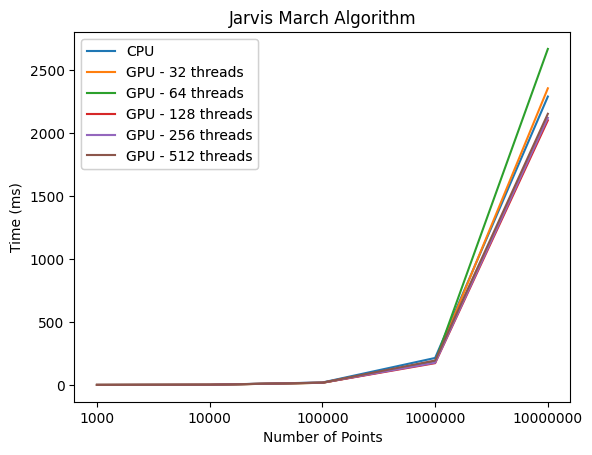

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

with open('jarvis-cpu.txt') as f:
    lines = f.readlines()
    x = [lines[ele].split()[0] for ele in range(0, len(lines), 2)]
    y1 = [float(lines[ele+1].split()[0]) for ele in range(0, len(lines), 2)]
    f.close()

y2_32 = []
y2_64 = []
y2_128 = []
y2_256 = []
y2_512 = []

with open('jarvis-gpu.txt') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        threads = lines[i].split()[0]
        if threads=='32':
            y2_32.append(float(lines[i+1]))
        elif threads=='64':
            y2_64.append(float(lines[i+1]))
        elif threads=='128':
            y2_128.append(float(lines[i+1]))
        elif threads=='256':
            y2_256.append(float(lines[i+1]))
        elif threads=='512':
            y2_512.append(float(lines[i+1]))

    f.close()

fig, ax = plt.subplots()
ax.plot(x, y1, label='CPU')
ax.plot(x, y2_32, label='GPU - 32 threads')
ax.plot(x, y2_64, label='GPU - 64 threads')
ax.plot(x, y2_128, label='GPU - 128 threads')
ax.plot(x, y2_256, label='GPU - 256 threads')
ax.plot(x, y2_512, label='GPU - 512 threads')

ax.set_xlabel('Number of Points')
ax.set_ylabel('Time (ms)')
ax.set_title('Jarvis March Algorithm')
legend1 = ax.legend(loc='upper left')

# Add the first legend back to the figure
ax.add_artist(legend1)

plt.show()


### **GRAHAM SCAN**

**GRAHAM SCAN CPU**

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

struct Point {
    int x;
    int y;
};

int compare(const void* vp1, const void* vp2) {
    struct Point* p1 = (struct Point*) vp1;
    struct Point* p2 = (struct Point*) vp2;

    if (p1->y < p2->y) {
        return -1;
    } else if (p1->y > p2->y) {
        return 1;
    } else {
        return p1->x - p2->x;
    }
}

int distSq(struct Point p1, struct Point p2) {
    return (p2.y - p1.y) * (p2.y - p1.y) + (p2.x - p1.x) * (p2.x - p1.x);
}

int orientation(struct Point p, struct Point q, struct Point r) {
    int val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y);
    if (val == 0) {
        return 0;
    } else if (val > 0) {
        return 1;
    } else {
        return 2;
    }
}

void swap(struct Point* p, struct Point* q) {
    struct Point temp = *p;
    *p = *q;
    *q = temp;
}


void convexHull(struct Point* points, int n) {
    struct Point hull[n];
    int top = -1;

    // Lower Hull
    for (int i = 0; i < n; i++) {
        while (top >= 1 && orientation(hull[top - 1], hull[top], points[i]) != 2) {
            top--;
        }

        top++;
        hull[top] = points[i];
    }

    // Upper Hull
    for (int i = n - 2, t = top + 1; i >= 0; i--) {
        while (top >= t && orientation(hull[top - 1], hull[top], points[i]) != 2) {
            top--;
        }

        top++;
        hull[top] = points[i];
    }

    // Print hull points
   // printf("Convex Hull Points:\n");
   // for (int i = 0; i <= top; i++) {
    //   printf("(%d, %d)\n", hull[i].x, hull[i].y);
    // }
}

int main() {
    
    int N_arr[5] = {1000, 10000, 100000, 1000000, 10000000};
      FILE *fp;
      fp = fopen("/content/graham-cpu.txt", "w+");
      char buffer[20] = {0}; 
      clock_t cpu_start, cpu_end;

      int N = 100;
       struct Point *points = (Point*) malloc(sizeof(struct Point) * N);
          srand(time(NULL));
        sprintf(buffer, "%d", N);
          fputs(buffer, fp);
          fputs("\n", fp);

            for (int i = 0; i < N; i++) {
            points[i].x = rand()  % 1000 + 1;
            points[i].y = rand()  % 1000 + 1;
          }

           qsort(points, N, sizeof(struct Point), compare);

           cpu_start = clock();
           convexHull(points, N);
           cpu_end = clock();
          double cpu_total_time = (double)(cpu_end - cpu_start) / CLOCKS_PER_SEC * 1000.0;

          sprintf(buffer, "%f", cpu_total_time);
          fputs(buffer, fp);
          fputs("\n", fp);
        

     free(points);





    // struct Point points[] = {{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};
  // int n = sizeof(points) / sizeof(points[0]);
    // convexHull(points, n);
    return 0;
}



**GRAHAM SCAN GPU**

In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <time.h>


struct Point {
    int x;
    int y;
};

__device__ int distSq(struct Point p1, struct Point p2) {
    return (p2.y - p1.y) * (p2.y - p1.y) + (p2.x - p1.x) * (p2.x - p1.x);
}

__device__ int orientation(struct Point p, struct Point q, struct Point r) {
    int val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y);
    if (val == 0) {
        return 0;
    } else if (val > 0) {
        return 1;
    } else {
        return 2;
    }
}

__device__ void swap(struct Point* p, struct Point* q) {
    struct Point temp = *p;
    *p = *q;
    *q = temp;
}

__global__ void convexHull(struct Point* points, int n, struct Point* hull) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid >= n) {
        return;
    }
    int top = -1;

    // Lower Hull
    for (int i = 0; i < n; i++) {
        while (top >= 1 && orientation(hull[top - 1], hull[top], points[i]) != 2) {
            top--;
        }

        top++;
        hull[top] = points[i];
    }

    // Upper Hull
    for (int i = n - 2, t = top + 1; i >= 0; i--) {
        while (top >= t && orientation(hull[top - 1], hull[top], points[i]) != 2) {
            top--;
        }

        top++;
        hull[top] = points[i];
    }
}

int comparePoints(const void* p1, const void* p2) {
    struct Point* point1 = (struct Point*) p1;
    struct Point* point2 = (struct Point*) p2;
    
    if (point1->x == point2->x) {
        return point1->y - point2->y;
    } else {
        return point1->x - point2->x;
    }
}

void sortPoints(struct Point* points, int n) {
    qsort(points, n, sizeof(struct Point), comparePoints);
}
int main() {
      FILE *fp;
      fp = fopen("/content/graham-gpu.txt", "w+");
    
      int N_arr[5] ={1000000};



   // int n = N;

    //printf("%d\n", n);

    // for (int i = 0; i < n; i++) {
     //   printf("(%d, %d)\n", h_hull[i].x, h_hull[i].y);
    //}


     for (int num_runs = 0; num_runs < 5; num_runs++){
          int N = N_arr[num_runs];   
          struct Point *points = (Point*) malloc(sizeof(struct Point) * N);
          srand(time(NULL));

          for (int i = 0; i < N; i++) {
            points[i].x = rand()  % 1000 + 1;
            points[i].y = rand()  % 1000 + 1;
          }

             sortPoints(points, N);
            struct Point* d_points;
            cudaMalloc(&d_points, N * sizeof(struct Point));
            cudaMemcpy(d_points, points, N * sizeof(struct Point), cudaMemcpyHostToDevice);
            struct Point* h_hull = (struct Point*)malloc(N * sizeof(struct Point));

            struct Point* d_hull;
            cudaMalloc(&d_hull, N * sizeof(struct Point));

           int N_threads[5] = {32, 64, 128, 256, 512};
           char buffer[20] = {0}; 
          sprintf(buffer, "%d", N);
          fputs(buffer, fp);
          fputs("\n", fp);


          for (int num_threads = 0; num_threads < 5; num_threads++){
                int threadsPerBlock = N_threads[num_threads];
                cudaEvent_t start, stop;
                float dt;

                sprintf(buffer, "%d", threadsPerBlock);
                fputs(buffer, fp);
                fputs("\n", fp);

                int numBlocks = (N + threadsPerBlock - 1) / threadsPerBlock;

                cudaEventCreate(&start);
                cudaEventCreate(&stop);

                cudaEventRecord(start, 0);
                convexHull<<<numBlocks, threadsPerBlock>>>(d_points, N, d_hull);
                cudaEventRecord(stop, 0);
                cudaEventSynchronize(stop);
                cudaEventElapsedTime(&dt, start, stop);

                sprintf(buffer, "%f", dt);
                fputs(buffer, fp);
                fputs("\n", fp);
                 cudaMemcpy(h_hull, d_hull, N * sizeof(struct Point), cudaMemcpyDeviceToHost);

              
       }     


       
        cudaFree(d_points);
        cudaFree(d_hull);
        free(h_hull);

       
       }

   
   

    // Print hull points
  //  printf("Convex Hull Points:\n");
  // for (int i = 0; i < n; i++) {
   // if (i == 0 || h_hull[i].x != h_hull[i-1].x || h_hull[i].y != h_hull[i-1].y) {
   //     printf("(%d, %d)\n", h_hull[i].x, h_hull[i].y);
   // }
//}
  //   printf("Total time for graham scan on GPU: %f msecs\n", dt);
 
    return 0;
}


[0.007, 0.096, 0.602, 3.289, 65.299]


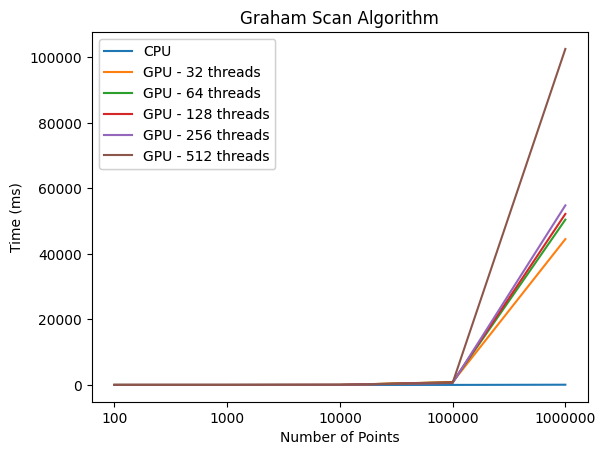

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

with open('graham-cpu.txt') as f:
    lines = f.readlines()
    x = [lines[ele].split()[0] for ele in range(0, len(lines), 2)]
    y1 = [float(lines[ele+1].split()[0]) for ele in range(0, len(lines), 2)]
    print(y1)
    f.close()

y2_32 = []
y2_64 = []
y2_128 = []
y2_256 = []
y2_512 = []

with open('graham-gpu.txt') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        threads = lines[i].split()[0]
        if threads=='32':
            y2_32.append(float(lines[i+1]))
        elif threads=='64':
            y2_64.append(float(lines[i+1]))
        elif threads=='128':
            y2_128.append(float(lines[i+1]))
        elif threads=='256':
            y2_256.append(float(lines[i+1]))
        elif threads=='512':
            y2_512.append(float(lines[i+1]))

    f.close()

fig, ax = plt.subplots()
ax.plot(x, y1, label='CPU')
ax.plot(x, y2_32, label='GPU - 32 threads')
ax.plot(x, y2_64, label='GPU - 64 threads')
ax.plot(x, y2_128, label='GPU - 128 threads')
ax.plot(x, y2_256, label='GPU - 256 threads')
ax.plot(x, y2_512, label='GPU - 512 threads')

ax.set_xlabel('Number of Points')
ax.set_ylabel('Time (ms)')
ax.set_title('Graham Scan Algorithm')
legend1 = ax.legend(loc='upper left')

# Add the first legend back to the figure
ax.add_artist(legend1)

plt.show()


### **CUDA CHAIN THRUST IMPLEMENTATION**

In [ ]:
%%cu
// Implement CudaChain convex hull algorithm on the GPU
// Original:
// Gang Mei, Institute of Earth and Enviromental Sciences
//           University of Freiburg, April 8, 2014
//           gang.mei@geologie.uni-freiburg.de
//           gangmeiphd@gmail.com
// Revised:
// Gang Mei, School of Engineeing and Technology,
//           China University of Geosciences, December 27, 2015
//           gang.mei@cugb.edu.cn
//           gangmeiphd@gmail.com
// Warning:  Ignore numerical non-robustness and geometrical degeneracies

#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/functional.h>
#include <thrust/partition.h>
#include <thrust/reverse.h>
#include <thrust/extrema.h>
#include <thrust/pair.h>
#include <thrust/sort.h>

#include <iostream>     
#include <stdlib.h>
#include <fstream>
#include <string>
#include <time.h>

using namespace std;

#define BLOCK_SIZE 1024
#define Point  float2

/////////////// Input & Output Interface ////////////////

// Input: Use the QHull input forrmat, i.e.,
/* Dimension  Number of points
// Corrdinates of Point 1
// Coordinates of Point 2
   ...                   */
void importQHull(thrust::host_vector<float> &pts_x,
                 thrust::host_vector<float> &pts_y)
{
    char str1[]="40064_2016_2284_MOESM2_ESM.txt";
    ifstream  fin (str1);
    if (!fin)
    {
        cout <<"\nCannot Open File ! " <<str1 <<endl;
        exit(1);
    }

    float x, y;
    int Dim, nVertex;
    fin >> Dim >> nVertex;
    pts_x.resize(nVertex);
    pts_y.resize(nVertex);

    for(int i = 0; i < nVertex; i++)
    {
        fin >> x >> y;
        pts_x[i] = x;
        pts_y[i] = y;
    }
    fin.close();

}

// Export the resulting convex hull to OFF file
void exportOFF(Point * pts, int n) // Use C/C++ arrays for exporting
{
    
    char str2[]="40064_2016_2284_MOESM2_ESM_OUT.off";
    ofstream fout (str2);
    if (!fout)
    {
        cout <<"\nCannot Save File ! " <<str2 <<endl;
        exit(1);
    }

    float x, y, z;
    int nVert = n;

    fout << "OFF" << endl;
    fout << nVert << "  " << 1 << "  " << 0 << endl;
    for(int i = 0; i< nVert; i++)
    {
        x = pts[i].x;
        y = pts[i].y;
        z = 0.0;
        fout <<  x <<"   "<< y<<"   "<< z << endl;
    }
    fout << nVert << "   ";

    for(int i = 0; i< nVert; i++)
    {
        fout << i <<"   ";
    }

    fout.close();

}

// Export the resulting convex hull to OFF file
void exportOFF(Point ** pts, int n) // Use C/C++ arrays for exporting
{
    char str2[]="40064_2016_2284_MOESM2_ESM_OUT.off";
    ofstream fout (str2);
    if (!fout)
    {
        cout <<"\nCannot Save File ! " <<str2 <<endl;
        exit(1);
    }

    double x, y, z;
    int ids[3];

    int nVert = n;

    fout << "OFF" << endl;
    fout << nVert << "  " << 1 << "  " << 0 << endl;
    for(int i = 0; i< nVert; i++)
    {
        x = pts[i]->x;
        y = pts[i]->y;
        z = 0.0;
        fout <<  x <<"   "<< y<<"   "<< z << endl;
    }
    fout << nVert << "   ";

    for(int i = 0; i< nVert; i++)
    {
        fout << i <<"   ";
    }

    fout.close();

}

// Export the resulting convex hull to OFF file
void exportOFF(const thrust::host_vector<float> &pts_x,
               const thrust::host_vector<float> &pts_y, int n) // Use thrust containers for exporting
{
    
    char str2[]="40064_2016_2284_MOESM2_ESM_OUT.off";
    ofstream fout (str2);
    if (!fout)
    {
        cout <<"\nCannot Save File ! " <<str2 <<endl;
        exit(1);
    }

    float x, y, z;
    int nVert = n;

    fout << "OFF" << endl;
    fout << nVert << "  " << 1 << "  " << 0 << endl;
    for(int i = 0; i< nVert; i++)
    {
        x = pts_x[i];
        y = pts_y[i];
        z = 0.0;
        fout <<  x <<"   "<< y<<"   "<< z << endl;
    }
    fout << nVert << "   ";

    for(int i = 0; i< nVert; i++)
    {
        fout << i <<"   ";
    }
	
    fout.close();

}

/////////////////////////////////////////////////////////
// isLeft():tests if a point is Left|On|Right of an infinite line.
// Input: three points P0, P1, and P2
// Return:
//	>0 for P2 left of the line through P0 and P1
// =0 for P2 on the line
// <0 for P2 right of the line
// See: Algorithm 1 on Area of Triangles
__host__ __device__
inline float isLeft( Point * P0, Point * P1, Point * P2 )
{
    return (P1->x - P0->x)*(P2->y - P0->y) - (P2->x - P0->x)*(P1->y - P0->y);
}

__host__ __device__
inline float isLeft( Point * P0, Point * P1, float &P2_x, float &P2_y )
{
    return (P1->x - P0->x)*(P2_y - P0->y) - (P2_x - P0->x)*(P1->y - P0->y);
}

// Check whether a point locates in a convex quadrilateral, for 1st discarding
__host__ __device__
int isInside( Point * P0, Point * P1, Point * P2, Point * P3, Point * pt)
{
    if(isLeft(P0, P1, pt) <= 0.0)  return 1; // In the sub-region 1
    if(isLeft(P1, P2, pt) <= 0.0)  return 2; // In the sub-region 2
    if(isLeft(P2, P3, pt) <= 0.0)  return 3; // In the sub-region 3
    if(isLeft(P3, P0, pt) <= 0.0)  return 4; // In the sub-region 4

    return 0;                                // In the sub-region 0
}

__host__ __device__
int isInside( Point * P0, Point * P1, Point * P2, Point * P3, float &pt_x, float &pt_y)
{
    if(isLeft(P0, P1, pt_x, pt_y) <= 0.0)  return 1;
    if(isLeft(P1, P2, pt_x, pt_y) <= 0.0)  return 2;
    if(isLeft(P2, P3, pt_x, pt_y) <= 0.0)  return 3;
    if(isLeft(P3, P0, pt_x, pt_y) <= 0.0)  return 4;

    return 0;
}

// Preprocess by discarding interior points, i.e., 1st round of discarding
__global__
void kernelPreprocess(float * h_extreme_x, float * h_extreme_y,
                      float * v_x, float * v_y, int * pos, int n)
{
    __shared__ float2 s_extreme[4]; // Stored in shared memory

    if(threadIdx.x == 0)
    {
        for(int t = 0; t < 4; t++)
        {
            s_extreme[t].x = h_extreme_x[t];
            s_extreme[t].y = h_extreme_y[t];
        }
    }
    __syncthreads();

    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if(i < n) // Check
    {
        pos[i] = isInside(&s_extreme[0], &s_extreme[1], 
			              &s_extreme[2], &s_extreme[3], v_x[i], v_y[i]);
    }
}


// Make predicate easy to write
typedef thrust::tuple<float, float, int > FloatTuple3;

// Predicate
struct is_interior_tuple
{
    __host__ __device__
    bool operator()(const FloatTuple3 & p)
    {
        return thrust::get<2>(p) > 0;
    }
};

struct is_region_1_tuple
{
    __host__ __device__
    bool operator()(const FloatTuple3 & p)
    {
        return thrust::get<2>(p) == 1;
    }
};

struct is_region_2_tuple
{
    __host__ __device__
    bool operator()(const FloatTuple3 & p)
    {
        return thrust::get<2>(p) == 2;
    }
};

struct is_region_3_tuple
{
    __host__ __device__
    bool operator()(const FloatTuple3 & p)
    {
        return thrust::get<2>(p) == 3;
    }
};

struct is_region_4_tuple
{
    __host__ __device__
    bool operator()(const FloatTuple3 & p)
    {
        return thrust::get<2>(p) == 4;
    }
};


// Discard invalid points in Region 1 (i.e., the lower left)
__global__
void kernelCheck_R1_device(float * V, int * pos, int base, int length)
{
    int i, id;
    float temp;
    int items = (length + BLOCK_SIZE - 1) / BLOCK_SIZE;

    if(BLOCK_SIZE == 1024)
    {
        temp = V[base];
            for(int t = 0; t < items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] > temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 512)
    {
        temp = V[base];
            for(int t = 0; t < 2 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] > temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 256)
    {
        temp = V[base];
            for(int t = 0; t < 4 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] > temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

}

// Discard invalid points in Region 2 (i.e., the lower right)
__global__
void kernelCheck_R2_device(float * V, int * pos, int base, int length)
{
    int i, id;
    float temp;
    int items = (length + BLOCK_SIZE - 1) / BLOCK_SIZE;

    if(BLOCK_SIZE == 1024)
    {
        temp = V[base];
            for(int t = 0; t < items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] < temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 512)
    {
        temp = V[base];
            for(int t = 0; t < 2 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] < temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 256)
    {
        temp = V[base];
            for(int t = 0; t < 4 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] < temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

}

// Discard invalid points in Region 3 (i.e., the upper right)
__global__
void kernelCheck_R3_device(float * V, int * pos, int base, int length)
{
    int i, id;
    float temp;
    int items = (length + BLOCK_SIZE - 1) / BLOCK_SIZE;

    if(BLOCK_SIZE == 1024)
    {
        temp = V[base];
            for(int t = 0; t < items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] < temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 512)
    {
        temp = V[base];
            for(int t = 0; t < 2 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] < temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 256)
    {
        temp = V[base];
            for(int t = 0; t < 4 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] < temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

}

// Discard invalid points in Region 4 (i.e., the upper left)
__global__
void kernelCheck_R4_device(float * V, int * pos, int base, int length)
{
    int i, id;
    float temp = V[base];
    int items = (length + BLOCK_SIZE - 1) / BLOCK_SIZE;

    if(BLOCK_SIZE == 1024)
    {
        temp = V[base];
            for(int t = 0; t < items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] > temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 512)
    {
        temp = V[base];
            for(int t = 0; t < 2 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] > temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

    if(BLOCK_SIZE == 256)
    {
        temp = V[base];
            for(int t = 0; t < 4 * items; t++)
            {
                i = threadIdx.x * items + t;
                id = i + base;
                if(i < length && pos[id] > 0)
                {
                    if(V[id] > temp) pos[id] = 0;
                    else temp = V[id];
                }
            }
    }

}


// Wrapper: CudaChain
int cudaChainNew(const thrust::host_vector<float> &x, const thrust::host_vector<float> &y,
                 thrust::host_vector<float> &hull_x, thrust::host_vector<float> &hull_y )
{
    int n = x.size(); // Number of points

	// Copy data from host side to device side
    thrust::device_vector<float> d_x = x;
    thrust::device_vector<float> d_y = y;

	typedef thrust::device_vector<float>::iterator                     FloatIter;

	// Find the four extreme points, i.e., min x, max x, min y, and max y
	thrust::pair<FloatIter, FloatIter> extremex = thrust::minmax_element(d_x.begin(), d_x.end());
	thrust::pair<FloatIter, FloatIter> extremey = thrust::minmax_element(d_y.begin(), d_y.end());

	// One method to find min / max (Correct)
	thrust::device_vector<float>::iterator minx = extremex.first;
	thrust::device_vector<float>::iterator maxx = extremex.second;
	thrust::device_vector<float>::iterator miny = extremey.first;
	thrust::device_vector<float>::iterator maxy = extremey.second;

	/* Another method to find min / max (Correct too)
    thrust::device_vector<float>::iterator minx = thrust::min_element(d_x.begin(), d_x.end());
    thrust::device_vector<float>::iterator maxx = thrust::max_element(d_x.begin(), d_x.end());
    thrust::device_vector<float>::iterator miny = thrust::min_element(d_y.begin(), d_y.end());
    thrust::device_vector<float>::iterator maxy = thrust::max_element(d_y.begin(), d_y.end());
	*/

	// Store the four extreme points temporarily
    thrust::device_vector<float> d_extreme_x(4);
    thrust::device_vector<float> d_extreme_y(4);

    d_extreme_x[0] = *minx;
    d_extreme_x[1] = d_x[miny - d_y.begin()];
    d_extreme_x[2] = *maxx;
    d_extreme_x[3] = d_x[maxy - d_y.begin()];

    d_extreme_y[0] = d_y[minx - d_x.begin()];
    d_extreme_y[1] = *miny;
    d_extreme_y[2] = d_y[maxx - d_x.begin()];
    d_extreme_y[3] = *maxy;

    thrust::device_vector<int> d_pos(n); // Indicators for points' position

	// Get the pointers to the arrays, to be used as launch arguments
    float * d_extreme_x_ptr = thrust::raw_pointer_cast(&d_extreme_x[0]);
    float * d_extreme_y_ptr = thrust::raw_pointer_cast(&d_extreme_y[0]);
    float * d_x_ptr = thrust::raw_pointer_cast(&d_x[0]);
    float * d_y_ptr = thrust::raw_pointer_cast(&d_y[0]);
    int * d_pos_ptr = thrust::raw_pointer_cast(&d_pos[0]);

    // 1st discarding :  Block size can be 1024 in this kernel
    kernelPreprocess<<<(n + 1023) / 1024, 1024>>>(d_extreme_x_ptr, d_extreme_y_ptr,
                                                  d_x_ptr, d_y_ptr, d_pos_ptr, n);

    // Set Extreme Points Specifically
    d_pos[minx - d_x.begin()] = 1;  // min X
    d_pos[miny - d_y.begin()] = 2;  // min Y
    d_pos[maxx - d_x.begin()] = 3;  // max X
    d_pos[maxy - d_y.begin()] = 4;  // max Y

    // Defining a zip_iterator type can be a little cumbersome ...
    typedef thrust::device_vector<float>::iterator                     FloatIterator;
    typedef thrust::device_vector<int>::iterator                       IntIterator;
    typedef thrust::tuple<FloatIterator, FloatIterator, IntIterator>   FloatIteratorTuple;
    typedef thrust::zip_iterator<FloatIteratorTuple>                   Float3Iterator;

    // create some zip_iterators
    Float3Iterator P_first = thrust::make_zip_iterator(thrust::make_tuple(d_x.begin(), d_y.begin(), d_pos.begin()));
    Float3Iterator P_last  = thrust::make_zip_iterator(thrust::make_tuple(d_x.end(),   d_y.end(),   d_pos.end()));

    // pass the zip_iterators into Partion()
    // Partion
    Float3Iterator first_of_R0 = thrust::partition(P_first, P_last, is_interior_tuple());                   // Find Interior
    Float3Iterator first_of_R2 = thrust::partition(P_first, first_of_R0-1, is_region_1_tuple());            // Find Region 1
    Float3Iterator first_of_R3 = thrust::partition(first_of_R2, first_of_R0-1, is_region_2_tuple());        // Find Region 2
    Float3Iterator first_of_R4 = thrust::partition(first_of_R3, first_of_R0-1, is_region_3_tuple());        // Find Region 3
//	Point * first_of_R4 = thrust::partition(first_of_R3, first_of_R0-1, is_region_4());   Not needed        // Find Region 4

    Float3Iterator first_of_R1 = P_first;

	// Get the position of the first points in each sub-region
    FloatIteratorTuple pos_R1 = first_of_R1.get_iterator_tuple();
    FloatIteratorTuple pos_R2 = first_of_R2.get_iterator_tuple();
    FloatIteratorTuple pos_R3 = first_of_R3.get_iterator_tuple();
    FloatIteratorTuple pos_R4 = first_of_R4.get_iterator_tuple();
    FloatIteratorTuple pos_R0 = first_of_R0.get_iterator_tuple();

    // Partly Sort for each sub-regions
    // Region 1 : ascending X
    FloatIterator first_of_R1_x = thrust::get<0>(pos_R1);
    FloatIterator first_of_R2_x = thrust::get<0>(pos_R2);
    thrust::sort_by_key(first_of_R1_x, first_of_R2_x, first_of_R1);

    // Region 2 : ascending Y
    FloatIterator first_of_R2_y = thrust::get<1>(pos_R2);
    FloatIterator first_of_R3_y = thrust::get<1>(pos_R3);
    thrust::sort_by_key(first_of_R2_y, first_of_R3_y, first_of_R2);

    // Region 3 : descending X
    FloatIterator first_of_R3_x = thrust::get<0>(pos_R3);
    FloatIterator first_of_R4_x = thrust::get<0>(pos_R4);
    thrust::sort_by_key(first_of_R3_x, first_of_R4_x, first_of_R3);
	  // Sort in ascending order, and then reverse
    thrust::reverse(thrust::get<0>(pos_R3), thrust::get<0>(pos_R4));
    thrust::reverse(thrust::get<1>(pos_R3), thrust::get<1>(pos_R4));
    thrust::reverse(thrust::get<2>(pos_R3), thrust::get<2>(pos_R4));

    // Region 4 : descending Y
    FloatIterator first_of_R4_y = thrust::get<1>(pos_R4);
    FloatIterator first_of_R0_y = thrust::get<1>(pos_R0);
    thrust::sort_by_key(first_of_R4_y, first_of_R0_y, first_of_R4);
	// Sort in ascending order, and then reverse
    thrust::reverse(thrust::get<0>(pos_R4), thrust::get<0>(pos_R0));
    thrust::reverse(thrust::get<1>(pos_R4), thrust::get<1>(pos_R0));
    thrust::reverse(thrust::get<2>(pos_R4), thrust::get<2>(pos_R0));

    // Kernel : 2nd round of discarding
    d_x_ptr   = thrust::raw_pointer_cast(&d_x[0]);
    d_y_ptr   = thrust::raw_pointer_cast(&d_y[0]);
    d_pos_ptr = thrust::raw_pointer_cast(&d_pos[0]);

    int base, length;

    // For each sub-region:  Single Block and Single Pass
	// Region 1
    base = 0;
    length = first_of_R2 - first_of_R1;
    kernelCheck_R1_device<<<1, BLOCK_SIZE>>>(d_y_ptr, d_pos_ptr, base, length);  // Only Y

	// Region 2
    base = first_of_R2 - first_of_R1;
    length = first_of_R3 - first_of_R2;
    kernelCheck_R2_device<<<1, BLOCK_SIZE>>>(d_x_ptr, d_pos_ptr, base, length);  // Only X

	// Region 3
    base = first_of_R3 - first_of_R1;
    length = first_of_R4 - first_of_R3;
    kernelCheck_R3_device<<<1, BLOCK_SIZE>>>(d_y_ptr, d_pos_ptr, base, length);  // Only Y

	// Region 4
    base = first_of_R4 - first_of_R1;
    length = first_of_R0 - first_of_R4;
    kernelCheck_R4_device<<<1, BLOCK_SIZE>>>(d_x_ptr, d_pos_ptr, base, length);  // Only X

    // Re-Partion, Note that: Use stable partition, rather than partition
    Float3Iterator first_of_invalid = thrust::stable_partition(first_of_R1, first_of_R0, is_interior_tuple());

    // Copy
    n = first_of_invalid - first_of_R1;
    thrust::copy_n(thrust::get<0>(pos_R1), n, hull_x.begin());
    thrust::copy_n(thrust::get<1>(pos_R1), n, hull_y.begin());

    return n;

}


// simpleHull_2D(): Melkman convex hull algorithm for simple polygon
//    Input:  V[] = polyline array of 2D vertex points (Note : CCW)
//            n   = the number of points in V[]
//    Output: H[] = output convex hull array of vertices (max is n)
//    Return: h   = the number of points in H[]
__host__ __device__
int simpleHull_2D( Point* V, int n, Point* H )
{
    // initialize a deque D[] from bottom to top so that the
    // 1st three vertices of V[] are a counterclockwise triangle
    Point* D = new Point[2*n+1];
    int bot = n-2, top = bot+3;   // initial bottom and top deque indices
    D[bot] = D[top] = V[2];       // 3rd vertex is at both bot and top
    if (isLeft(&V[0], &V[1], &V[2]) > 0)
    {
        D[bot+1] = V[0];
        D[bot+2] = V[1];          // ccw vertices are: 2,0,1,2
    }
    else
    {
        D[bot+1] = V[1];
        D[bot+2] = V[0];          // ccw vertices are: 2,1,0,2
    }

    // compute the hull on the deque D[]
    for (int i=3; i < n; i++)     // process the rest of vertices
    {
        // test if next vertex is inside the deque hull
        if ((isLeft(&D[bot], &D[bot+1], &V[i]) > 0) &&
                (isLeft(&D[top-1], &D[top], &V[i]) > 0) )
            continue;         // skip an interior vertex

        // incrementally add an exterior vertex to the deque hull
        // get the rightmost tangent at the deque bot
        while (isLeft(&D[bot], &D[bot+1], &V[i]) <= 0)
            ++bot;                // remove bot of deque
        D[--bot] = V[i];          // insert V[i] at bot of deque

        // get the leftmost tangent at the deque top
        while (isLeft(&D[top-1], &D[top], &V[i]) <= 0)
            --top;                // pop top of deque
        D[++top] = V[i];          // push V[i] onto top of deque
    }

    // transcribe deque D[] to the output hull array H[]
    int h;        // hull vertex counter
    for (h=0; h <= (top-bot); h++)
        H[h] = D[bot + h];

    delete D;
    return h-1;
}

////////////////////////////////////////////////////////////////////////////////

int main(int argc, char **argv)
{
    std::cout << "\nBLOCK_SIZE :  "  << BLOCK_SIZE << '\n';

	// Host containers for storing x and y
    thrust::host_vector<float> ipts_x;
    thrust::host_vector<float> ipts_y;

	// Input points
    importQHull(ipts_x, ipts_y);

    int n = ipts_x.size();

    thrust::host_vector<float> opts_x(n);
    thrust::host_vector<float> opts_y(n);

	// Perform 1st and 2nd rounds of discarding
    int h = cudaChainNew(ipts_x, ipts_y, opts_x, opts_y); 

	// Finalize the computing of expected convex hull, i.e., 
	// Calculate the convex hull of a simple polygon
	Point * opts = new Point[h];
    for(int i = 0; i < h; i++) {
    	opts[i].x = opts_x[i];
    	opts[i].y = opts_y[i];
    }
    Point * H = new Point[h];
    h = simpleHull_2D( opts, h, H );

	// Output: to OFF file format
    exportOFF(H, h);

  	delete [] opts;
    printf("Successfully executed");

    return 0;
}



BLOCK_SIZE :  1024
Successfully executed


### **QUICK HULL ALGORITHM - OWN IMPLEMENTATION**

#### **CPU IMPLEMENTATION**
Reference: https://timiskhakov.github.io/posts/computing-the-convex-hull-on-gpu


In [ ]:
%%cu
#include <iostream>
#include <vector>
#include <unordered_set>
#include <cmath>
#include <ctime>

struct Point
{
    float X;
    float Y;

    Point(float x, float y) : X(x), Y(y) {}
    struct Hash {
        std::size_t operator()(const Point& p) const {
          // Use std::hash to hash the x and y coordinates
          return std::hash<int>()(p.X) ^ std::hash<int>()(p.Y);
        }
      };

    // Define equality operator for Point
    bool operator==(const Point& other) const {
      return X == other.X && Y == other.Y;
    }
};

double Distance(Point p1, Point p2, Point p)
{
    return std::abs((p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X));
}

int Side(Point p1, Point p2, Point p)
{
    float side = (p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X);
    if (side > 0)
        return 1;
    if (side < 0)
        return -1;
    return 0;
}

void FindHull(std::vector<Point>& points, Point p1, Point p2, int side, std::unordered_set<Point, Point::Hash>& result)
{
    int maxIndex = -1;
    double maxDistance = 0.0;
    for (int i = 0; i < points.size(); i++)
    {
        if (Side(p1, p2, points[i]) != side)
            continue;

        double distance = Distance(p1, p2, points[i]);
        if (distance <= maxDistance)
            continue;

        maxIndex = i;
        maxDistance = distance;
    }

    if (maxIndex == -1)
    {
        result.insert(p1);
        result.insert(p2);
        return;
    }

    int newSide = Side(points[maxIndex], p1, p2);
    FindHull(points, points[maxIndex], p1, -newSide, result);
    FindHull(points, points[maxIndex], p2, newSide, result);
}

std::unordered_set<Point, Point::Hash> QuickHull(std::vector<Point>& points)
{
    if (points.size() <= 2)
        throw std::invalid_argument("Too little points: " + std::to_string(points.size()) + ", expected 3 or more");

    std::unordered_set<Point, Point::Hash> result;


    Point left = points[0], right = points[0];
    for (int i = 1; i < points.size(); i++)
    {
        if (points[i].X < left.X)
            left = points[i];
        if (points[i].X > right.X)
            right = points[i];
    }

    FindHull(points, left, right, 1, result);
    FindHull(points, left, right, -1, result);

    return result;
}
int main()
{
  // Create a vector of points
  std::vector<Point> points = {{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};

  // Call QuickHull function
  clock_t start = clock();
  std::unordered_set<Point, Point::Hash> hull = QuickHull(points);
  clock_t end = clock();
  double duration = static_cast<double>(end - start) / CLOCKS_PER_SEC;
  std::cout << "Time taken: " << duration*1000 << " milliseconds" << std::endl;
  // Print the points in the convex hull
  std::cout << "Convex Hull Points:" << std::endl;
  for (const auto& point : hull)
  {
    std::cout << "(" << point.X << ", " << point.Y << ")" << std::endl;
  }

  return 0;
}

Time taken: 0.009 milliseconds
Convex Hull Points:
(3, 1)
(0, 0)
(4, 4)
(0, 3)



#### **CPU IMPLEMENTATION WITH OPENMP**

In [ ]:
%%writefile quickopenmp.cpp
#include <iostream>
#include <vector>
#include <unordered_set>
#include <cmath>
#include <stdexcept>
#include <omp.h> // Include OpenMP header

struct Point
{
  float X;
  float Y;

  Point(float x, float y) : X(x), Y(y) {}
    struct Hash {
        std::size_t operator()(const Point& p) const {
          // Use std::hash to hash the x and y coordinates
          return std::hash<int>()(p.X) ^ std::hash<int>()(p.Y);
        }
      };

    // Define equality operator for Point
    bool operator==(const Point& other) const {
      return X == other.X && Y == other.Y;
    }
};

double Distance(Point p1, Point p2, Point p)
{
  return std::abs((p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X));
}

int Side(Point p1, Point p2, Point p)
{
  auto side = (p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X);
  if (side > 0) return 1;
  if (side < 0) return -1;
  return 0;
}

void FindHull(std::vector<Point>& points, Point p1, Point p2, int side, std::unordered_set<Point, Point::Hash>& result)
{
  int maxIndex = -1;
  double maxDistance = 0.0;
  
  #pragma omp parallel for // Add OpenMP pragma to enable parallelism
  for (int i = 0; i < points.size(); i++)
  {
    int localMaxIndex = -1;
    double localMaxDistance = 0.0;
    #pragma omp critical // Add critical section to safely update maxIndex and maxDistance
    {
      if (Side(p1, p2, points[i]) == side)
      {
        double distance = Distance(p1, p2, points[i]);
        if (distance > maxDistance)
        {
          maxDistance = distance;
          maxIndex = i;
        }
      }
    }
  }

  if (maxIndex == -1)
  {
    #pragma omp critical // Add critical section to safely insert points into the result
    {
      result.insert(p1);
      result.insert(p2);
    }
    return;
  }

  int newSide = Side(points[maxIndex], p1, p2);
  FindHull(points, points[maxIndex], p1, -newSide, result);
  FindHull(points, points[maxIndex], p2, newSide, result);
}

std::unordered_set<Point, Point::Hash> QuickHull(std::vector<Point>& points)
{
  if (points.size() <= 2) throw std::invalid_argument("Too little points, expected 3 or more");

  std::unordered_set<Point, Point::Hash> result;

  Point left = points[0], right = points[0];
  for (int i = 1; i < points.size(); i++)
  {
    if (points[i].X < left.X) left = points[i];
    if (points[i].X > right.X) right = points[i];
  }

  FindHull(points, left, right, 1, result);
  FindHull(points, left, right, -1, result);

  return result;
}

int main()
{
  // Create a vector of points
  //std::vector<Point> points = {{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};
  std::vector<Point> points;
    srand(time(NULL));
    srand(time(NULL));
    for (int i = 0; i < 1000; i++) {
      points.push_back(Point((float)rand()/(float)(RAND_MAX/5.0), (float)rand()/(float)(RAND_MAX/5.0)));
  }
  std::cout << "Number of points: " << points.size() << std::endl;
  std::unordered_set<Point, Point::Hash> convexHull;
  double start_time = omp_get_wtime(); // Record start time
  convexHull = QuickHull(points);
  double end_time = omp_get_wtime(); // Record end time

  // Print convex hull points
  /*std::cout << "Convex Hull Points: ";
  for (const auto& point : convexHull)
  {
  std::cout << "(" << point.X << ", " << point.Y << ") ";
  }
  std::cout << std::endl;
  */
  std::cout << convexHull.size()<<std::endl;
  // Print execution time
  printf("%f ms", (end_time - start_time)*1000);

  return 0;
}

Overwriting quickopenmp.cpp


In [ ]:
!g++ -o quickopenmp quickopenmp.cpp -fopenmp

In [ ]:
!./quickopenmp

Number of points: 1000
20
1.087330 ms

#### **GPU IMPLEMENTATION**

First one does not have preprocessing and has print statements for debugging

In [ ]:
%%cu
#include <iostream>
#include <vector>
#include <unordered_set>
#include <cmath>
#include <stdexcept>
#include <cuda_runtime.h> // Include CUDA header
#define BLOCK_SIZE 256
__host__ __device__ struct Point
{
  float X;
  float Y;

  __host__ __device__ Point(float x, float y) : X(x), Y(y) {}
 
  __host__ __device__  struct Hash {
        __host__ __device__ std::size_t operator()(const Point& p) const {
          // Use std::hash to hash the x and y coordinates
          return std::hash<int>()(p.X) ^ std::hash<int>()(p.Y);
        }
      };

   __host__ __device__ bool operator==(const Point& other) const {
      return X == other.X && Y == other.Y;
    }
};

__device__ void atomicAssign(int* var, int val)
{
    atomicExch(var, val);
}

__device__ void atomicAssignFloat(float* var, float val)
{
    atomicExch(var, val);
}

__host__ __device__ struct DataBlock{
    int index;
    float distance;
    __host__ __device__ DataBlock(){}
    __host__ __device__ DataBlock(int _index, float _distance) : index(_index), distance(_distance) {}
};

__host__ __device__ double Distance(Point p1, Point p2, Point p)
{
  return std::abs((p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X));
}

__host__ __device__ int Side(Point p1, Point p2, Point p)
{
  auto side = (p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X);
  if (side > 0) return 1;
  if (side < 0) return -1;
  return 0;
}

__device__ void FindMaxIndexGPU(Point a, Point b, Point candidate, int side, int candidateIndex, int* maxIndex, float* maxDistance)
{
    int s = Side(a, b, candidate);
    if (s != side) return;
    
    double candidateDistance = Distance(a, b, candidate);
 
    if (candidateDistance > *maxDistance){
      //atomicExch(maxIndex, candidateIndex);
      //atomicMax(maxDistance, candidateDistance);
      *maxIndex = candidateIndex;
      *maxDistance = candidateDistance;
    }
 
}

__host__  void FindMaxIndexCPU(Point a, Point b, Point candidate, int side, int candidateIndex, int* maxIndex, float* maxDistance)
{
    int s = Side(a, b, candidate);
    if (s != side) return;
    
    double candidateDistance = Distance(a, b, candidate);
    if (candidateDistance > *maxDistance){
    *maxIndex = candidateIndex;
    *maxDistance = candidateDistance;
 }
}

__global__ void FindMaxIndexKernel(
            Point* input,
            int length,
            int side,
            Point a,
            Point b,
            DataBlock* output)
{
    // Define a shared memory buffer to hold the results of the thread-level computation
    __shared__ float s_distance[BLOCK_SIZE];
    __shared__ int s_index[BLOCK_SIZE];

    // Compute the start index for this block
    int start_index = blockIdx.x * blockDim.x;
    
    // Initialize the thread-level results with default values
    float distance = -1.0f;
    int index = -1;
    
    // Compute the maximum distance and index for the points assigned to this block
    for (int i = threadIdx.x; i < blockDim.x && start_index + i < length; i += blockDim.x)
    {
        FindMaxIndexGPU(a, b, input[start_index + i], side, start_index + i, &index, &distance);
    }
    __syncthreads();
 
    s_distance[threadIdx.x] = distance;
    s_index[threadIdx.x] = index;
    __syncthreads();
    // Perform a reduction within the block to find the maximum distance and index
    for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1)
    {
        if (threadIdx.x < s)
        {
            printf("Thread %d NextThread %d Stride %d NextDistance %f CurrentDistance %f\n", threadIdx.x, threadIdx.x + s, s, s_distance[threadIdx.x + s], distance);
            if (s_distance[threadIdx.x + s] > distance)
            {
                distance = s_distance[threadIdx.x + s];
                index = s_index[threadIdx.x + s];
                s_index[threadIdx.x] = index;
                s_distance[threadIdx.x] = distance;
            }
        }
        __syncthreads();
    }

    // Only the first thread of each block needs to write the results to global memory
    if (threadIdx.x == 0)
    {
        output[blockIdx.x] = DataBlock(index, distance);
    }
}

void FindHull(std::vector<Point>& points, Point p1, Point p2, int side, std::unordered_set<Point, Point::Hash>& result, Point* d_points)
{
    dim3 gridDim, blockDim;
    int minGridSize;
    blockDim.x = BLOCK_SIZE;
    gridDim.x = (points.size() + blockDim.x - 1) / blockDim.x;
    printf("Kernel Config: %d, %d\n", gridDim.x, blockDim.x);
    printf("Kernel Call: (%f %f), (%f %f), %d\n", p1.X, p1.Y, p2.X, p2.Y, side);

    DataBlock* d_output;
    std::vector<DataBlock> output(gridDim.x);
    cudaMalloc((void**)&d_output, gridDim.x * sizeof(DataBlock));
    FindMaxIndexKernel<<<gridDim, blockDim>>>(d_points, points.size(), side, p1, p2, d_output);
    cudaDeviceSynchronize();
    cudaMemcpy(output.data(), d_output, gridDim.x * sizeof(DataBlock), cudaMemcpyDeviceToHost);
    int maxIndex = -1;
    float maxDistance = 0.0;

    for (const auto& candidate : output) {
        if (candidate.index < 0) continue;
        printf("here: %d, %f \n", candidate.index, candidate.distance);

        FindMaxIndexCPU(p1, p2, points[candidate.index], side, candidate.index, &maxIndex, &maxDistance);
        
    }
    if (maxIndex == -1)
    {
        result.insert(p1);
        result.insert(p2);
        return;
    }

    int newSide = Side(points[maxIndex], p1, p2);
    FindHull(points, points[maxIndex], p1, -newSide, result, d_points);
    FindHull(points, points[maxIndex], p2, newSide, result, d_points);
  }

std::unordered_set<Point, Point::Hash> QuickHull(std::vector<Point>& points)
{
    if (points.size() <= 2)
        throw std::invalid_argument("Too little points: " + std::to_string(points.size()) + ", expected 3 or more");

    std::unordered_set<Point, Point::Hash> result;

    Point left = points[0], right = points[0];
    for (int i = 1; i < points.size(); i++)
    {
        if (points[i].X < left.X)
            left = points[i];
        if (points[i].X > right.X)
            right = points[i];
    }
    
    Point* d_points;
    cudaMalloc((void**)&d_points, points.size() * sizeof(Point));
    cudaMemcpy(d_points, points.data(), points.size() * sizeof(Point), cudaMemcpyHostToDevice);

    
    FindHull(points, left, right, 1, result, d_points);
    FindHull(points, left, right, -1, result, d_points);
 
    return result;
}

int main()
{
  // Create a vector of points
  //std::vector<Point> points = {{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};
  std::vector<Point> points;
    srand(time(NULL));
    srand(time(NULL));
    for (int i = 0; i < 20; i++) {
      points.push_back(Point((float)rand()/(float)(RAND_MAX/5.0), (float)rand()/(float)(RAND_MAX/5.0)));
  }
  std::cout << "Number of points: " << points.size() << std::endl;
  clock_t start = clock();
  std::unordered_set<Point, Point::Hash> hull = QuickHull(points);
  clock_t end = clock();
  double duration = static_cast<double>(end - start) / CLOCKS_PER_SEC;
  std::cout << "Time taken: " << duration*1000 << " milliseconds" << std::endl;
  // Print the points in the convex hull
  std::cout << "Convex Hull Points:" << std::endl;
  for (const auto& point : hull)
  {
    std::cout << "(" << point.X << ", " << point.Y << ")" << std::endl;
  }
  return 0;
}

Number of points: 20
Kernel Config: 1, 256
Kernel Call: (0.248694 4.406803), (4.744380 4.962253), 1
Thread 0 NextThread 128 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 1 NextThread 129 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 2 NextThread 130 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 3 NextThread 131 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 4 NextThread 132 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 5 NextThread 133 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 6 NextThread 134 Stride 128 NextDistance -1.000000 CurrentDistance 1.620571
Thread 7 NextThread 135 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 8 NextThread 136 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 9 NextThread 137 Stride 128 NextDistance -1.000000 CurrentDistance -1.000000
Thread 10 NextThread 138 Stride 128 NextDistance -1.000000 Cu

#### **GPU IMPLEMENTATION WITH PREPROCESSING AND DISCARDING**

In [ ]:
%%cu
#include <iostream>
#include <vector>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/sort.h>
#include <thrust/extrema.h>
#include <unordered_set>
#include <cmath>
#include <stdexcept>
#include <cuda_runtime.h> // Include CUDA header

#define BLOCK_SIZE 256
__host__ __device__ struct Point
{
  float X;
  float Y;

  __host__ __device__ Point(float x, float y) : X(x), Y(y) {}
 __host__ __device__ Point() : X(0.0), Y(0.0) {}
 
  __host__ __device__  struct Hash {
        __host__ __device__ std::size_t operator()(const Point& p) const {
          // Use std::hash to hash the x and y coordinates
          return std::hash<int>()(p.X) ^ std::hash<int>()(p.Y);
        }
      };

   __host__ __device__ bool operator==(const Point& other) const {
      return X == other.X && Y == other.Y;
    }
};

__device__ void atomicAssign(int* var, int val)
{
    atomicExch(var, val);
}

__device__ void atomicAssignFloat(float* var, float val)
{
    atomicExch(var, val);
}

__host__ __device__ struct DataBlock{
    int index;
    float distance;
    __host__ __device__ DataBlock(){}
    __host__ __device__ DataBlock(int _index, float _distance) : index(_index), distance(_distance) {}
};

__host__ __device__ double Distance(Point p1, Point p2, Point p)
{
  return std::abs((p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X));
}

__host__ __device__ int Side(Point p1, Point p2, Point p)
{
  auto side = (p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X);
  if (side > 0) return 1;
  if (side < 0) return -1;
  return 0;
}

__device__ void FindMaxIndexGPU(Point a, Point b, Point candidate, int side, int candidateIndex, int* maxIndex, float* maxDistance)
{
    int s = Side(a, b, candidate);
    if (s != side) return;
    
    double candidateDistance = Distance(a, b, candidate);
 
    if (candidateDistance > *maxDistance){
      //atomicExch(maxIndex, candidateIndex);
      //atomicMax(maxDistance, candidateDistance);
      *maxIndex = candidateIndex;
      *maxDistance = candidateDistance;
    }
 
}

__host__  void FindMaxIndexCPU(Point a, Point b, Point candidate, int side, int candidateIndex, int* maxIndex, float* maxDistance)
{
    int s = Side(a, b, candidate);
    if (s != side) return;
    
    double candidateDistance = Distance(a, b, candidate);
    if (candidateDistance > *maxDistance){
    //printf("in here");
    *maxIndex = candidateIndex;
    *maxDistance = candidateDistance;
 }
}

__global__ void FindMaxIndexKernel(
            Point* input,
            int length,
            int side,
            Point a,
            Point b,
            DataBlock* output)
{
    // Define a shared memory buffer to hold the results of the thread-level computation
    __shared__ float s_distance[BLOCK_SIZE];
    __shared__ int s_index[BLOCK_SIZE];

    // Compute the start index for this block
    int start_index = blockIdx.x * blockDim.x;
    
    // Initialize the thread-level results with default values
    float distance = -1.0f;
    int index = -1;
    
    // Compute the maximum distance and index for the points assigned to this block
    for (int i = threadIdx.x; i < blockDim.x && start_index + i < length; i += blockDim.x)
    {
        FindMaxIndexGPU(a, b, input[start_index + i], side, start_index + i, &index, &distance);
    }
    __syncthreads();
 
    s_distance[threadIdx.x] = distance;
    s_index[threadIdx.x] = index;
    __syncthreads();
    for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1)
    {
        if (threadIdx.x < s)
        {
            if (s_distance[threadIdx.x + s] > distance)
            {
                distance = s_distance[threadIdx.x + s];
                index = s_index[threadIdx.x + s];
                s_index[threadIdx.x] = index;
                s_distance[threadIdx.x] = distance;
            }
        }
        __syncthreads();
    }

    // Only the first thread of each block needs to write the results to global memory
    if (threadIdx.x == 0)
    {
        output[blockIdx.x] = DataBlock(index, distance);
    }
}

void FindHull(std::vector<Point>& points, Point p1, Point p2, int side, std::unordered_set<Point, Point::Hash>& result, Point* d_points)
{
    dim3 gridDim, blockDim;
    int minGridSize;
    blockDim.x = BLOCK_SIZE;
    gridDim.x = (points.size() + blockDim.x - 1) / blockDim.x;
    //printf("Config: %d, %d\n", gridDim.x, blockDim.x);
    //printf("Call: (%f %f), (%f %f), %d\n", p1.X, p1.Y, p2.X, p2.Y, side);

    DataBlock* d_output;
    std::vector<DataBlock> output(gridDim.x);
    cudaMalloc((void**)&d_output, gridDim.x * sizeof(DataBlock));
    FindMaxIndexKernel<<<gridDim, blockDim>>>(d_points, points.size(), side, p1, p2, d_output);
    cudaDeviceSynchronize();
    cudaMemcpy(output.data(), d_output, gridDim.x * sizeof(DataBlock), cudaMemcpyDeviceToHost);
    int maxIndex = -1;
    float maxDistance = 0.0;

    for (const auto& candidate : output) {
        if (candidate.index < 0) continue;
        //printf("here: %d, %f \n", candidate.index, candidate.distance);

        FindMaxIndexCPU(p1, p2, points[candidate.index], side, candidate.index, &maxIndex, &maxDistance);
        
    }
    if (maxIndex == -1)
    {
        result.insert(p1);
        result.insert(p2);
        return;
    }

    int newSide = Side(points[maxIndex], p1, p2);
    FindHull(points, points[maxIndex], p1, -newSide, result, d_points);
    FindHull(points, points[maxIndex], p2, newSide, result, d_points);
  }

std::unordered_set<Point, Point::Hash> QuickHull(std::vector<Point>& points)
{
    if (points.size() <= 2)
        throw std::invalid_argument("Too little points: " + std::to_string(points.size()) + ", expected 3 or more");

    std::unordered_set<Point, Point::Hash> result;

    Point left = points[0], right = points[0];
    for (int i = 1; i < points.size(); i++)
    {
        if (points[i].X < left.X)
            left = points[i];
        if (points[i].X > right.X)
            right = points[i];
    }
    
    Point* d_points;
    cudaMalloc((void**)&d_points, points.size() * sizeof(Point));
    cudaMemcpy(d_points, points.data(), points.size() * sizeof(Point), cudaMemcpyHostToDevice);

    
    FindHull(points, left, right, 1, result, d_points);
    FindHull(points, left, right, -1, result, d_points);
 
    return result;
}
struct CompareX
{
    __host__ __device__ bool operator()(const Point& a, const Point& b) const
    {
        return a.X < b.X;
    }
};

struct CompareY
{
    __host__ __device__ bool operator()(const Point& a, const Point& b) const
    {
        return a.Y < b.Y;
    }
};

struct IsInsideQuadrilateral
{
  const Point leftmost;
  const Point rightmost;
  const Point topmost;
  const Point bottommost;

  __host__ __device__ IsInsideQuadrilateral(Point left, Point top, Point right, Point bottom)
    : leftmost(left),  topmost(top), rightmost(right), bottommost(bottom)
  {}

  __host__ __device__ bool operator()(const Point& p) const
{
  float eps = 1e-6;
  if (p==topmost || p==leftmost || p==rightmost || p==bottommost)
    return false;
  float cp1 = (topmost.X - leftmost.X) * (p.Y - leftmost.Y) - (p.X - leftmost.X) * (topmost.Y - leftmost.Y);
  float cp2 = (rightmost.X - topmost.X) * (p.Y - topmost.Y) - (p.X - topmost.X) * (rightmost.Y - topmost.Y);
  float cp3 = (bottommost.X - rightmost.X) * (p.Y - rightmost.Y) - (p.X - rightmost.X) * (bottommost.Y - rightmost.Y);
  float cp4 = (p.X - bottommost.X) * (bottommost.Y - leftmost.Y) - (bottommost.X - leftmost.X) * (p.Y - bottommost.Y);

  // Check if the cross products are non-negative and have the same sign.
  return (cp1 >= -eps && cp2 >= -eps && cp3 >= -eps && cp4 >= -eps) ||
         (cp1 <= eps && cp2 <= eps && cp3 <= eps && cp4 <= eps);
}
};


int main()
{
  //std::vector<Point> points ={{1, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0.5}, {1, 2}, {3, 0}, {3, 3}, {5,3}};
  std::vector<Point> points;
    srand(time(NULL));
    srand(time(NULL));
    for (int i = 0; i < 20000000; i++) {
      points.push_back(Point((float)rand()/(float)(RAND_MAX/100.0), (float)rand()/(float)(RAND_MAX/100.0)));
  }
  std::cout << "Number of points: " << points.size() << std::endl;
  thrust::device_vector<Point> d_points(points);
  clock_t start = clock();
  Point leftmost = *thrust::min_element(d_points.begin(), d_points.end(), CompareX());
  Point rightmost = *thrust::max_element(d_points.begin(), d_points.end(), CompareX());
  Point bottommost = *thrust::min_element(d_points.begin(), d_points.end(), CompareY());
  Point topmost = *thrust::max_element(d_points.begin(), d_points.end(), CompareY());
  printf("Leftmost point: (%f, %f)\n", leftmost.X, leftmost.Y);
  printf("Rightmost point: (%f, %f)\n", rightmost.X, rightmost.Y);
  printf("Topmost point: (%f, %f)\n", topmost.X, topmost.Y);
  printf("Bottommost point: (%f, %f)\n", bottommost.X, bottommost.Y);
  auto new_end = thrust::remove_if(d_points.begin(), d_points.end(), IsInsideQuadrilateral(leftmost, topmost, rightmost, bottommost));
  d_points.erase(new_end, d_points.end());
  points.resize(d_points.size());
  thrust::copy(d_points.begin(), d_points.end(), points.begin());
  std::cout << "Number of filtered points: " << points.size() << std::endl;
  std::unordered_set<Point, Point::Hash> hull = QuickHull(points);
  clock_t end = clock();
  double duration = static_cast<double>(end - start) / CLOCKS_PER_SEC;
  std::cout << "Time taken: " << duration*1000 << " milliseconds" << std::endl;
  // Print the points in the convex hull
  std::cout << "Convex Hull Points:" << hull.size() <<std::endl;
  /*for (const auto& point : hull)
  {
    std::cout << "(" << point.X << ", " << point.Y << ")" << std::endl;
  }*/
  return 0;
}

Number of points: 20000000
Leftmost point: (0.000008, 29.862133)
Rightmost point: (100.000000, 8.942779)
Topmost point: (84.385071, 100.000000)
Bottommost point: (96.977623, 0.000003)
Number of filtered points: 10263425
Time taken: 296.99 milliseconds
Convex Hull Points:46



Just a simple GPU implementation with proof of concept.

In [ ]:
%%cu
#include <iostream>
#include <vector>
#include <unordered_set>
#include <cmath>
#include <stdexcept>
#include <cuda_runtime.h> // Include CUDA header

__host__ __device__ struct Point
{
  float X;
  float Y;

  __host__ __device__ Point(float x, float y) : X(x), Y(y) {}
 
  __host__ __device__  struct Hash {
        __host__ __device__ std::size_t operator()(const Point& p) const {
          // Use std::hash to hash the x and y coordinates
          return std::hash<int>()(p.X) ^ std::hash<int>()(p.Y);
        }
      };

   __host__ __device__ bool operator==(const Point& other) const {
      return X == other.X && Y == other.Y;
    }
};

__device__ void atomicAssign(int* var, int val)
{
    atomicExch(var, val);
}

__device__ void atomicAssignFloat(float* var, float val)
{
    atomicExch(var, val);
}



__host__ __device__ struct DataBlock{
    int index;
    float distance;
    __host__ __device__ DataBlock(){}
    __host__ __device__ DataBlock(int _index, float _distance) : index(_index), distance(_distance) {}
};

__host__ __device__ double Distance(Point p1, Point p2, Point p)
{
  return std::abs((p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X));
}

__host__ __device__ int Side(Point p1, Point p2, Point p)
{
  auto side = (p.Y - p1.Y) * (p2.X - p1.X) - (p2.Y - p1.Y) * (p.X - p1.X);
  if (side > 0) return 1;
  if (side < 0) return -1;
  return 0;
}

__device__ void FindMaxIndexGPU(Point a, Point b, Point candidate, int side, int candidateIndex, int* maxIndex, float* maxDistance)
{
    int s = Side(a, b, candidate);
    printf("findmaxind GPU: (%f %f), (%f %f), (%f %f), %d, %d\n", a.X, a.Y, b.X, b.Y, candidate.X, candidate.Y, side, s);
    if (s != side) return;
    
    double candidateDistance = Distance(a, b, candidate);
    printf("findmaxind GPU Copy: (%f %f), (%f %f), (%f %f), %d, %d\n", a.X, a.Y, b.X, b.Y, candidate.X, candidate.Y, side, s);
    printf("candidate distance GPU: %f %d and maxDistance %f %d\n", candidateDistance, candidateIndex, *maxDistance, *maxIndex);
 
    if (candidateDistance > *maxDistance){
      printf("in here\n");
      //atomicExch(maxIndex, candidateIndex);
      //atomicMax(maxDistance, candidateDistance);
      *maxIndex = candidateIndex;
      *maxDistance = candidateDistance;
      printf("after atomic assign %d %f\n", *maxIndex, *maxDistance);
    }
 
}

__host__  void FindMaxIndexCPU(Point a, Point b, Point candidate, int side, int candidateIndex, int* maxIndex, float* maxDistance)
{
    int s = Side(a, b, candidate);
    printf("findmaxind CPU: (%f %f), (%f %f), (%f %f), %d, %d\n", a.X, a.Y, b.X, b.Y, candidate.X, candidate.Y, side, s);
    if (s != side) return;
    
    double candidateDistance = Distance(a, b, candidate);
    printf("candidate distance: %f %d and maxDistance %f \n", candidateDistance, candidateIndex, *maxDistance);
    if (candidateDistance > *maxDistance){
    printf("in here");
    *maxIndex = candidateIndex;
    *maxDistance = candidateDistance;
    printf("max Distance CPU: %f \n", *maxDistance);
 }
}

__global__ void FindMaxIndexKernel(
            Point* input,
            int length,
            int side,
            Point a,
            Point b,
            DataBlock* output)
{
    // Define a shared memory buffer to hold the results of the thread-level computation
    __shared__ float s_distance[16];
    __shared__ int s_index[16];

    // Compute the start index for this block
    int start_index = blockIdx.x * blockDim.x;
    
    // Initialize the thread-level results with default values
    float distance = -1.0f;
    int index = -1;
    
    // Compute the maximum distance and index for the points assigned to this block
    for (int i = threadIdx.x; i < blockDim.x && start_index + i < length; i += blockDim.x)
    {
        FindMaxIndexGPU(a, b, input[start_index + i], side, start_index + i, &index, &distance);
    }
    __syncthreads();
 
    s_distance[threadIdx.x] = distance;
    s_index[threadIdx.x] = index;
    __syncthreads();
    // Perform a reduction within the block to find the maximum distance and index
    //printf("SM written for thread %d %f %d \n", threadIdx.x, s_distance[threadIdx.x], s_index[threadIdx.x]);
    for (unsigned int s = blockDim.x / 2; s > 0; s >>= 1)
    {
        if (threadIdx.x < s)
        {
            //printf("Thread %d NextThread %d Stride %d NextDistance %f CurrentDistance %f\n", threadIdx.x, threadIdx.x + s, s, s_distance[threadIdx.x + s], distance);
            if (s_distance[threadIdx.x + s] > distance)
            {
                printf("distance %f should be updated by nextdistance %f\n", distance, s_distance[threadIdx.x + s]);
                distance = s_distance[threadIdx.x + s];
                index = s_index[threadIdx.x + s];
                s_index[threadIdx.x] = index;
                s_distance[threadIdx.x] = distance;
                //printf("distance %f  nextdistance %f\n", distance, s_distance[threadIdx.x + s]);
            }
            //printf("syncthreads called\n");
        }
        __syncthreads();
    }

    // Only the first thread of each block needs to write the results to global memory
    if (threadIdx.x == 0)
    {
        output[blockIdx.x] = DataBlock(index, distance);
        //printf("written to output %d %f\n", output[blockIdx.x].index, output[blockIdx.x].distance );
    }
}

void FindHull(std::vector<Point>& points, Point p1, Point p2, int side, std::unordered_set<Point, Point::Hash>& result, Point* d_points)
{
    dim3 gridDim, blockDim;
    int minGridSize;
    blockDim.x = 16;
    gridDim.x = (points.size() + blockDim.x - 1) / blockDim.x;
    printf("Config: %d, %d\n", gridDim.x, blockDim.x);
    printf("Call: (%f %f), (%f %f), %d\n", p1.X, p1.Y, p2.X, p2.Y, side);

    DataBlock* d_output;
    std::vector<DataBlock> output(gridDim.x);
    cudaMalloc((void**)&d_output, gridDim.x * sizeof(DataBlock));
    FindMaxIndexKernel<<<gridDim, blockDim>>>(d_points, points.size(), side, p1, p2, d_output);
    cudaDeviceSynchronize();
    cudaMemcpy(output.data(), d_output, gridDim.x * sizeof(DataBlock), cudaMemcpyDeviceToHost);
    int maxIndex = -1;
    float maxDistance = 0.0;

    for (const auto& candidate : output) {
        if (candidate.index < 0) continue;
        printf("here: %d, %f \n", candidate.index, candidate.distance);

        FindMaxIndexCPU(p1, p2, points[candidate.index], side, candidate.index, &maxIndex, &maxDistance);
        
    }
    if (maxIndex == -1)
    {
        result.insert(p1);
        result.insert(p2);
        return;
    }

    int newSide = Side(points[maxIndex], p1, p2);
    FindHull(points, points[maxIndex], p1, -newSide, result, d_points);
    FindHull(points, points[maxIndex], p2, newSide, result, d_points);
  }

std::unordered_set<Point, Point::Hash> QuickHull(std::vector<Point>& points)
{
    if (points.size() <= 2)
        throw std::invalid_argument("Too little points: " + std::to_string(points.size()) + ", expected 3 or more");

    std::unordered_set<Point, Point::Hash> result;

    Point left = points[0], right = points[0];
    for (int i = 1; i < points.size(); i++)
    {
        if (points[i].X < left.X)
            left = points[i];
        if (points[i].X > right.X)
            right = points[i];
    }
    
    Point* d_points;
    cudaMalloc((void**)&d_points, points.size() * sizeof(Point));
    cudaMemcpy(d_points, points.data(), points.size() * sizeof(Point), cudaMemcpyHostToDevice);

    
    FindHull(points, left, right, 1, result, d_points);
    FindHull(points, left, right, -1, result, d_points);
 
    return result;
}

int main()
{
  // Create a vector of points
  std::vector<Point> points ={{0, 3}, {1, 1}, {2, 2}, {4, 4}, {0, 0}, {1, 2}, {3, 1}, {3, 3}};
  printf("here\n");
  clock_t start = clock();
  std::unordered_set<Point, Point::Hash> hull = QuickHull(points);
  clock_t end = clock();
  double duration = static_cast<double>(end - start) / CLOCKS_PER_SEC;
  std::cout << "Time taken: " << duration << " seconds" << std::endl;
  // Print the points in the convex hull
  std::cout << "Convex Hull Points:" << std::endl;
  for (const auto& point : hull)
  {
    std::cout << "(" << point.X << ", " << point.Y << ")" << std::endl;
  }
  return 0;
}

here
Config: 1, 16
Call: (0.000000 3.000000), (4.000000 4.000000), 1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (0.000000 3.000000), 1, 0
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (1.000000 1.000000), 1, -1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (2.000000 2.000000), 1, -1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (4.000000 4.000000), 1, 0
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (0.000000 0.000000), 1, -1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (1.000000 2.000000), 1, -1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (3.000000 1.000000), 1, -1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (3.000000 3.000000), 1, -1
Config: 1, 16
Call: (0.000000 3.000000), (4.000000 4.000000), -1
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (0.000000 3.000000), -1, 0
findmaxind GPU: (0.000000 3.000000), (4.000000 4.000000), (1.000000 1.000000), -1, -1
findmaxind GPU: (

#### **DATASET**

Potential future work of testing with 2D projection of stanford graphics models

In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.8/680.8 KB 11.6 MB/s eta 0:00:00


In [ ]:
import trimesh

# Load the mesh from the .ply file
mesh = trimesh.load("/content/dragonStandRight_0.ply")

# Project the vertices to a 2D plane
projection = mesh.vertices[:, :2]

# Export the 2D projection as a list of points
points = projection.tolist()
with open('dragon.txt','a') as f:
  for p in points:
    f.write(f"{p[0]} {p[1]}\n")